## HW02 Code

### Name: Irina Mengqi Wang

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2021/comp135/home).

In [21]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [22]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [23]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [24]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [25]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
    
    i = 0
    for d in polynomials:
        # transform the data 
        poly = PolynomialFeatures(d)
        transX = poly.fit_transform(x)
        
        # predict the model
        reg = linear_model.LinearRegression()
        reg.fit(transX, y)
        
        # calculate the predicted value 
        prediction_list.append(reg.predict(transX))

        # calculate the error 
        error_list.append(mean_squared_error(y, prediction_list[i]))
        i += 1
    
    return prediction_list, error_list
    

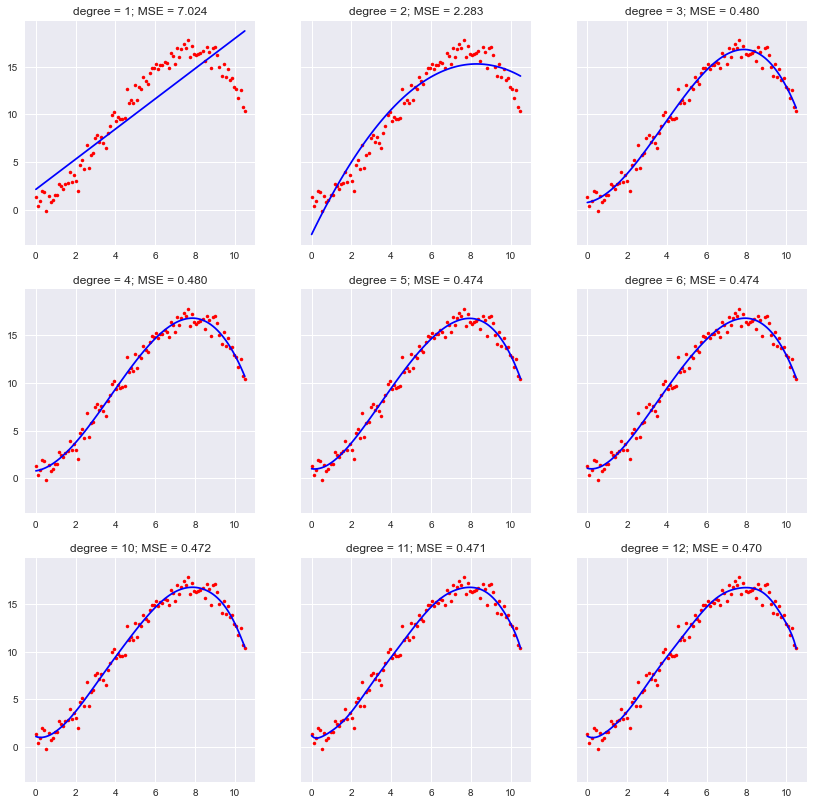

In [26]:
d = [1,2,3,4,5,6,10,11,12]
pred, err = test_polynomials(d)
plot_predictions(d, pred, err)


#### 1.2 Discuss the results seen in the plots above

**Discussion**:  What do they show? What is the best model, based upon MSE? What models do particularly poorly? What does this tell you?

The results show that as the degrees get higher, the line we generate fits the model better and the MSE gets smaller. The best model appears at degree 12, which gives the smallest MSE. Lower degrees perform poorly, especially the degree-1 linear regression, which deviates greatly from the data. This confirms that at lower degrees when there aren't enough predictors, the graphh generate poor prediction; and as the the polynomial degree gets higher, it's more likely to give better results. 

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [27]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    data_len, _ = data.shape
 
    i = 0
    fold_size = data_len // num_folds
    for i in range(num_folds):
        x_folds.append(x[i*fold_size:(i+1)*fold_size])
        y_folds.append(y[i*fold_size:(i+1)*fold_size])
    
    
    return x_folds, y_folds

In [28]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)


k = 5
x_folds, y_folds = make_folds(k)

for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

In [29]:
def k_folds_cross_validation(folds, polynomials=list()):
    '''Perform k-folds cross-validation for each polynomial degree.  
        Keep track of average training/test error for each degree; 
    
    Args
    ----
    folds: number of folds
    
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
        
        Returns
        ----
        test_meanMSE: list of error values((# polynomials models) * 1)
            Each value is a mean squared error of the model in the test set.
        train_meanMSE:  list of error values((# polynomials models) * 1)
            Each value is a mean squared error of the model in the train set.
    '''
    
    x_folds, y_folds = make_folds(folds)
    x_folds = np.array(x_folds)
    y_folds = np.array(y_folds)
    
    test_meanMSE = list()
    train_meanMSE = list()
    
    
    for d in polynomials:
        i = 0
        test_pred = []
        train_pred = []
        train_error = []
        test_error = []
        for k in range(folds):
            
            test_X = x_folds[k]
            test_Y = y_folds[k]
            
            train_X = np.delete(x_folds, k, 0).flatten().reshape(-1,1)
            train_Y = np.delete(y_folds, k, 0).flatten()
            
            # transform the data 
            poly = PolynomialFeatures(d)
            trans_train_X = poly.fit_transform(train_X)
            trans_test_X = poly.fit_transform(test_X)
            
            # predict the model
            reg = linear_model.LinearRegression()
            reg.fit(trans_train_X, train_Y)

            # train error
            train_pred.append(reg.predict(trans_train_X))
            train_error.append(mean_squared_error(train_Y, train_pred[i]))
            
            # test error
            test_pred.append(reg.predict(trans_test_X))
            test_error.append(mean_squared_error(test_Y, test_pred[i]))
            i += 1
        # average error
        test_meanMSE.append(np.average(test_error))
        train_meanMSE.append(np.average(train_error))
    
    return test_meanMSE, train_meanMSE

In [30]:
polynomial = [1,2,3,4,5,6,10,11,12]

test_meanMSE, train_meanMSE = k_folds_cross_validation(k, polynomial)

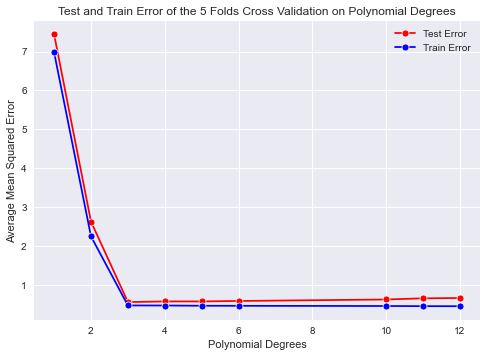

In [31]:
# Plot results in a single table, properly labeled
# graph title
plt.title('Test and Train Error of the 5 Folds Cross Validation on Polynomial Degrees') 

# naming the x axis & y axis
plt.xlabel('Polynomial Degrees') 
plt.ylabel('Average Mean Squared Error') 

# plot the graph
sns.lineplot(x = polynomial, y = test_meanMSE, label = "Test Error", color = "red", marker='o')
sns.lineplot(x = polynomial, y = train_meanMSE,label = "Train Error", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.show()

In [32]:
# print out the results in clear tabular format
pd.DataFrame(np.transpose([polynomial, test_meanMSE, train_meanMSE]), columns=['Poly Degree', 'Test Error', 'Train Error'])

,Poly Degree,Test Error,Train Error
0,1.0,7.441157,6.977641
1,2.0,2.625608,2.245920
2,3.0,0.558083,0.471621
3,4.0,0.574623,0.469909
4,5.0,0.574580,0.463663
5,6.0,0.586606,0.462069
6,10.0,0.624748,0.457199
7,11.0,0.654949,0.453294
8,12.0,0.662661,0.451891


#### 2.3 Discuss the results seen in the plots above

Discuss the plotted results. What do they show? Where do we see the best results? Where is their underfitting, and why do you say that? Where is there overfitting, and why do you say that?

Both train and test data underwent similar changes as they drastically decrease in the Mean Squared Error(MSE) from degree 1 to degree 3; However, while the MSE in train data continue to decrease in mean squared error from degree 3 to 12, the MSE in test data start to slowly increase. At degree 3, we see best results, as the test error reaches the minimum value in the data set. At degree 1 and 2, we see the data underfitting as the error in test data can be further reduced and train data is also high. And at degree 4 and above, we see the data overfitting, since even though we can still improve the training data, the error in test data start to increase and becomes much bigger than the train error. 

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

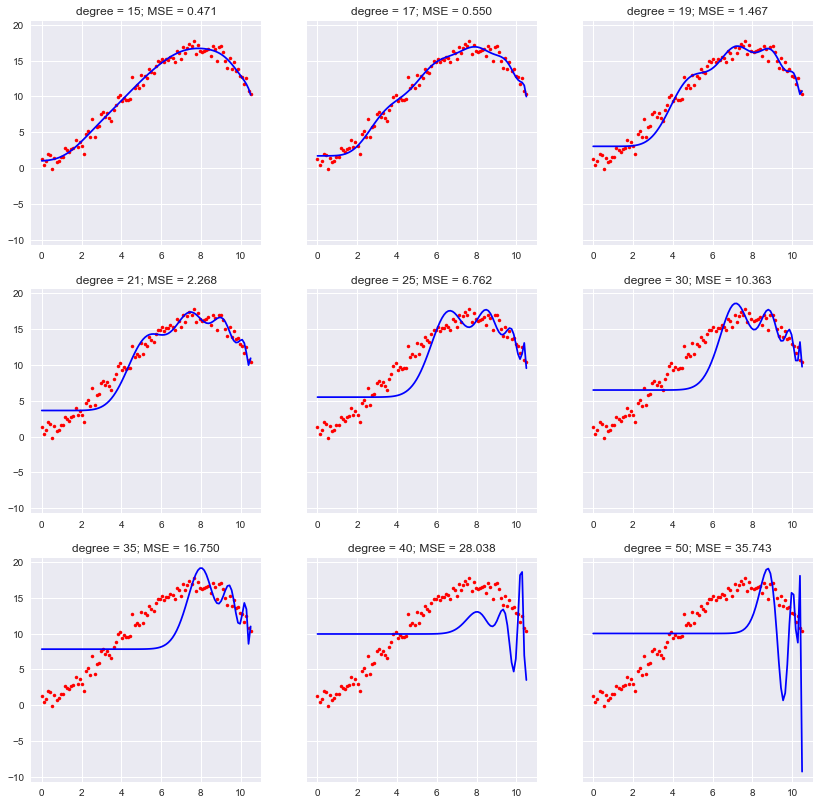

In [33]:
d_new = [15, 17, 19, 21, 25, 30, 35, 40, 50]

pred, err = test_polynomials(d_new)
plot_predictions(d_new, pred, err)

#### 3.2 Discuss the results seen in the plots above

Discuss the plotted results. What do they show us, and why do you think they look the way they do? (You will want to do a little research online or otherwise to help you answer this question.)

As the degree gets beyond 15 and shoots really high, the graph starts to act weirdly. It tries to produce models that have jagged, curvy line to aggressively cover as many points. However, the almost flat line on the left side indicates it fails to generate a proper line. We see high variance in data and an unexpected increase in the mean squared error as the degree goes up.

This is because in the sklearn library, the matrix algebra starts to break down at arbitrarily large degrees. We are doing a very, very high degree polynomial transformations on very small dataset, and the library does this because there's no point of producing a model with excessive features and complexity. It makes total sense since even if it works well in the mathematical sense, the model would be meaningless for it's surely overfitting. 

When I did some research online, I found that the scikit learn team warned people against using large numbers with polynomial regression ---- the expansion to a 9th-degree polynomial is nonsense, especially with small data sets. It also says scikit learn is built for practical use cases, and it works with finite-precision representations, not theoretical representations. In fact, I used numpy originally and it gave me perfect results. 
 

In [34]:
# numpy way of doing this 
#     i = 0
#     for d in polynomials:
#         # predict the model
#         p = np.polyfit(x_1d, y, d)

#         # calculate the predicted value 
#         prediction_list.append(np.polyval(p, x_1d))

#         # calculate the error 
#         error_list.append(mean_squared_error(y, prediction_list[i]))
#         i += 1

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

In [35]:
# Note, I use degree 3 because it gives the best performance on the dataset.

In [36]:
# Does 5-folds cross-validation
x_folds, y_folds = make_folds(5)
x_folds = np.array(x_folds)
y_folds = np.array(y_folds)
    
ridge_test_error = list()
ridge_train_error = list()

# Generate ridge panelties 
weight = np.logspace(-2, 2, base=10, num=50)

for w in weight:
    i = 0
    test_pred = []
    train_pred = []
    train_error = []
    test_error = []
    for k in range(5):
        test_X = x_folds[k]
        test_Y = y_folds[k]

        train_X = np.delete(x_folds, k, 0).flatten().reshape(-1,1)
        train_Y = np.delete(y_folds, k, 0).flatten()

        # transform the data with degree-3 polynomial
        poly = PolynomialFeatures(3)
        trans_train_X = poly.fit_transform(train_X)
        trans_test_X = poly.fit_transform(test_X)

        # predict the model      
        rig = linear_model.Ridge(w)
        rig.fit(trans_train_X, train_Y)

        # train error
        train_pred.append(rig.predict(trans_train_X))
        train_error.append(mean_squared_error(train_Y, train_pred[i]))

        # test error
        test_pred.append(rig.predict(trans_test_X))
        test_error.append(mean_squared_error(test_Y, test_pred[i]))
        i += 1
    # average error
    ridge_test_error.append(np.average(test_error))
    ridge_train_error.append(np.average(train_error))


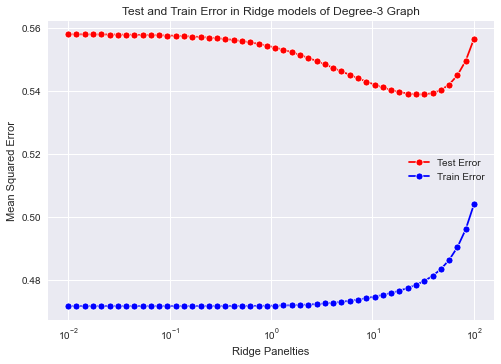

In [37]:
# graph title
plt.title('Test and Train Error in Ridge models of Degree-3 Graph') 

# naming the x axis & y axis
plt.xlabel('Ridge Panelties') 
plt.ylabel('Mean Squared Error') 

# plot the graph
sns.lineplot(x = weight, y = ridge_test_error, label = "Test Error", color = "red", marker='o')
sns.lineplot(x = weight, y = ridge_train_error, label = "Train Error", color = "blue", marker='o')

# show a legend on the plot 
plt.xscale('log')
plt.legend() 
plt.show()


In [38]:
# print out the results in clear tabular format
pd.DataFrame(np.transpose([weight, ridge_test_error, ridge_train_error]), columns=['Ridge Penalties', 'Test Error', 'Train Error'])

,Ridge Penalties,Test Error,Train Error
0,0.010000,0.558036,0.471621
1,0.012068,0.558026,0.471621
2,0.014563,0.558015,0.471621
3,0.017575,0.558001,0.471621
4,0.021210,0.557984,0.471621
5,0.025595,0.557963,0.471621
6,0.030888,0.557939,0.471621
7,0.037276,0.557909,0.471621
8,0.044984,0.557873,0.471621
9,0.054287,0.557831,0.471621


#### 4.2 Discuss the results seen in the plots above
Where is the effect of increasing regularization strength helpful in avoiding overfitting, does it appear, and why do you say that? Where is the effect less useful, and why do you say that?


**Discussion**:  The results show that while increasing regularization strength help decrease the mean error results in the test data to certain degree, it begins overfitting as the error rebounce up beyond the weight of 32.374575 (or between 26.826958 and 32.374575). Before the ridge panelty reaches 32.374575, we see high test error, indicating it's less helpful when the penalty is too low. Similarly, as the panelty exceeds over 32.374575, the both test and train error begin to increase, making it harder to converge.